In [2]:
from datasets import load_dataset, Dataset
import sys, os, json, re
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm.auto import tqdm, trange
from rouge import Rouge
import ollama

modelfile = """
FROM {model}
PARAMETER temperature {temperature}
"""
ollama.create(model="gemma:2b_TEMP0", modelfile=modelfile.format(model="gemma:2b", temperature=0.0))
ollama.create(model="gemma:2b_TEMP1", modelfile=modelfile.format(model="gemma:2b", temperature=1.0))
ollama.create(model="llama3_TEMP0", modelfile=modelfile.format(model="llama3", temperature=0.0))
ollama.create(model="llama3_TEMP1", modelfile=modelfile.format(model="llama3", temperature=1.0))

def rouge_scorer():
    # Initialize the Rouge object
    rouge = Rouge()

    def compute_scores(generated_text, reference_text):
        # Compute the scores
        scores = rouge.get_scores(generated_text, reference_text)[0]
        total_score = 0
        for r in scores:
            total_score += scores[r]['f']
        return total_score/3

    return compute_scores

def check_and_reformat(prompt):
    """
    Checks if prompt is valid. If prompt is valid, returns a slightly modified prompt that can be evaluated and optimized.
    """
    pattern1 = r'{[^}]*}'
    pattern2 = r'PLACEHOLDER'
    matches1 = re.findall(pattern1, prompt)
    matches2 = re.findall(pattern2, prompt.upper())
    print(matches1, matches2)

    assert len(matches1) == 1 or len(matches2) == 1, "Invalid prompt format. Prompt must contain some str/var to be interpolated."

    # Reformat the prompt
    if len(matches1) == 1:
        return prompt.replace(matches1[0], "{TEXT}")
    else:
        return prompt.replace(matches2[0], "{TEXT}")

# Usage
score_rouge = rouge_scorer()
CHOSEN_PROMPT = 'Please summarize the following text: PLACEHOLDER'  # somewhere in promptset. Will find idx later
CHOSEN_PROMPT = check_and_reformat(CHOSEN_PROMPT)
CHOSEN_PROMPT

[] ['PLACEHOLDER']


'Please summarize the following text: {TEXT}'

### Generate Synthetic Data

In [3]:
# Generate a question and answer pair using a language model
def generate_synthetic_data(sample_size = 40):
    # Check if the synthetic data already exists
    SYNTHETIC_DATA_FILEPATH = "synthetic_summarization_dataset.json"
    if os.path.exists(SYNTHETIC_DATA_FILEPATH):
        # Reading saved data
        with open(SYNTHETIC_DATA_FILEPATH, "r") as f:
            text_summary_pairs = eval(f.read())
        return text_summary_pairs

    def generate_synthetic_datapoint():
        prompt_template = """You are a helpful assistant designed to generate synthetic text-summary pairs for the prompt: {CHOSEN_PROMPT}.

    Please generate synthetic data for the summarization prompt. Response with a JSON object with "text" and "summary" keys. The values must both be string values.

    Take a deep breath and think step-by-step. Respond with only the JSON object!
    """

        response = ollama.generate(model="llama3_TEMP1", prompt=prompt_template.format(CHOSEN_PROMPT=CHOSEN_PROMPT))["response"]
        print(response)
        return eval(response)

    text_summary_pairs = []

    # Generating synthetic data
    pbar = tqdm(total=sample_size)
    while len(text_summary_pairs) < sample_size:
        try:
            data_pair = generate_synthetic_datapoint()
            text_summary_pairs.append(data_pair)
            pbar.update(1)
        except Exception as e:
            print(e)
    pbar.close()

    # Saving to file
    with open(SYNTHETIC_DATA_FILEPATH, "w") as f:
        f.write(str(text_summary_pairs))

    return text_summary_pairs

synthetic_data = generate_synthetic_data()
synthetic_data[:5]

[{'text': "The sun was setting over the vast ocean, casting a warm orange glow over the waves. The salty air filled with the cries of seagulls as they swooped down to investigate the beachcomber's latest treasure find. A lone surfer paddled out to catch the last few waves of the day, the sound of the water rushing past his board the only soundtrack needed. As the stars began to twinkle in the night sky, a group of friends gathered around a roaring bonfire, sharing stories and laughter as they watched the fireworks display in the distance.",
  'summary': 'A serene beach scene at sunset, with surfers, seagulls, and a bonfire, as the day ends with a fireworks display in the distance.'},
 {'text': "The new smartphone app, named 'EcoLife', aims to encourage users to adopt more environmentally friendly habits by providing personalized recommendations and rewards. Users can track their progress and earn badges for achieving milestones. The app's AI-powered algorithm analyzes user data to offe

In [4]:
TRAINING_SAMPLE_SIZE = 10
TESTING_SAMPLE_SIZE = 30

training_sample = synthetic_data[:TRAINING_SAMPLE_SIZE]

testing_sample = synthetic_data[TRAINING_SAMPLE_SIZE:TRAINING_SAMPLE_SIZE+TESTING_SAMPLE_SIZE]

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample), len(testing_sample)

(10, 30)

### Optimize Prompt on Synthetic Data

In [5]:
# Scoring the instruction using the sample
def opt_llm(prompt_score_pairs):
    has_correct_keywords = lambda prompt: re.findall(r'{(.*?)}', prompt) == ['TEXT']
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in prompt_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    # prompt = """Below is the set of optimization...

    # Following is the better prompt..

    # TODO: Remove 1st/2nd person narrative.

    
    # """

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

Here are some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""
    response = ""
    while not has_correct_keywords(response):
        response = ollama.generate(model="llama3_TEMP1", prompt=prompt.format(pairs_str=pairs_str))["response"]
    return response


def score(prompt, sample):
    """
    Score the instruction using the sample.

    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    accuracy = 0
    with tqdm(sample, desc=prompt, position=1, leave=False) as pbar:
        for idx, data_pair in enumerate(pbar):
            res = ollama.generate(model="gemma:2b_TEMP0", prompt=prompt.format(TEXT=data_pair["text"]))["response"]
            # Heuristic for detecting correctness
            accuracy += score_rouge(res, data_pair["summary"])
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [6]:
SEED_PROMPTS = [
CHOSEN_PROMPT,
f"{CHOSEN_PROMPT}. Think step by step.",
f"{CHOSEN_PROMPT}. Take a deep breath.",
f"{CHOSEN_PROMPT}. Be concise and clear.",
f"{CHOSEN_PROMPT}. You are a summarization expert.",
f"{CHOSEN_PROMPT}. Explain your answer in simple terms.",
f"{CHOSEN_PROMPT}. You are a helpful assistant.",
# Prompt1 from Suggest Prompt
"""#### Instruction ####

Summarize the following text:

#### Input ####

{TEXT}

#### Expected Response Format ####

[Your summary]""",
# Prompt2 from Suggest Prompt
"""**Instruction**: Summarize the following text:

**{TEXT}**

**Example:**

* Summarize the following text:
> The United States is a large country with a diverse population. It is made up of 50 states, each with its own unique culture and history. The United States is a global superpower and has a significant influence on world affairs.

### Answer: ###
* The United States is a large, diverse country with 50 states, each with its own unique culture and history. As a global superpower, the United States exerts significant influence on world affairs.

**Additional Instructions:**

* Please ensure that your summary captures the key points of the text.
* Use clear and concise language.
* You MUST adhere to the specified word limit.
* You will be penalized if your summary is not responsive to the text.""",
# Prompt3 from Suggest Prompt
"""###Instruction###

Summarize the following text:

###Input###
{TEXT}

###Your task is###

Generate a concise and accurate summary of the input text.

###You MUST###

* Write in clear and concise language.
* Cover all the main points of the text.
* Keep the summary within 500 words.

###You will be penalized if###

* Your summary is incomplete or inaccurate.
* Your summary exceeds the 500-word limit.

###Answer in a natural, human-like manner###

Pretend you are a highly skilled human summarizing the text.

###Example###
* **QUESTION:** Summarize the following text:
{{EXAMPLE TEXT}}
* **SUMMARY:** {{EXAMPLE SUMMARY}}

###TIP###
I'm going to tip $5 for a better summary!""",
# Prompt4 from Suggest Prompt
"""###Instruction###
Your task is to summarize the following text:


###Example###
{TEXT}


You MUST answer in a natural, human-like manner. You will be penalized for not following these instructions.
###Question###
{TEXT}""",
# Prompt5 from Suggest Prompt
"""###Instruction###
Provide a concise summary of the following text:
{TEXT}
###Example###
Input: Here is the provided request: \"Summarize this research paper: Effects of Climate Change on Marine Ecosystems\"
Output: Marine ecosystems face significant threats from climate change, including rising sea temperatures, ocean acidification, and altered weather patterns. These changes disrupt ecological balances, leading to loss of biodiversity, shifts in species distribution, and reduced productivity.
###Question###
Your task is to generate a concise and informative summary of the provided text. Ensure your response is clear, concise, and free from errors. You MUST adhere to the formatting guidelines and provide a single cohesive summary. If you fail to meet these requirements, you will be penalized.
Answer in a natural, human-like manner and ensure your response is comprehensive and covers the main points of the provided text.""",
]

SEED_PROMPTS

['Please summarize the following text: {TEXT}',
 'Please summarize the following text: {TEXT}. Think step by step.',
 'Please summarize the following text: {TEXT}. Take a deep breath.',
 'Please summarize the following text: {TEXT}. Be concise and clear.',
 'Please summarize the following text: {TEXT}. You are a summarization expert.',
 'Please summarize the following text: {TEXT}. Explain your answer in simple terms.',
 'Please summarize the following text: {TEXT}. You are a helpful assistant.',
 '#### Instruction ####\n\nSummarize the following text:\n\n#### Input ####\n\n{TEXT}\n\n#### Expected Response Format ####\n\n[Your summary]',
 '**Instruction**: Summarize the following text:\n\n**{TEXT}**\n\n**Example:**\n\n* Summarize the following text:\n> The United States is a large country with a diverse population. It is made up of 50 states, each with its own unique culture and history. The United States is a global superpower and has a significant influence on world affairs.\n\n### A

In [7]:
INS_PER_STEP = 8
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "synthetic_summarization_OPRO_results.json"
STEP_COUNT = 10

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    ins_score_pairs = results[str(len(results))]
else:
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(SEED_PROMPTS, desc="Scoring", position=0)
    }
    results = {1: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
for i in range(1, STEP_COUNT + 1):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            instructions = [
                opt_llm(ins_score_pairs)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]
            print(instructions)

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            print(new_ins_score_pairs)
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

Step 1


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['**Instruction**: Illuminate the significance of the following text:\n\n**{TEXT}**\n\nPlease generate a summary that captures the essence of the provided text in a clear and concise manner. Use language that is natural and human-like. The summary should be comprehensive, covering all the main points, and adhere to the specified word limit.\n\nNote: Your response will be judged based on its clarity, concision, accuracy, and relevance to the original text.', '**Instruction**: Synthesize complex ideas by summarizing the following text:\n\n**{TEXT}**\n\nYour task is to generate a concise and informative summary of the provided text. Ensure your response is clear, concise, and free from errors. You MUST adhere to the formatting guidelines and provide a single cohesive summary. If you fail to meet these requirements, you will be penalized.\n\nWrite in a natural, human-like manner and ensure your response is comprehensive, covering all main points of the provided text.', "**Instruction**: Sy

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Instruction**: Illuminate the significance of the following text:

**{TEXT}**

Please generate a summary tha…

**Instruction**: Synthesize complex ideas by summarizing the following text:

**{TEXT}**

Your task is to gene…

**Instruction**: Synthesize the following knowledge:

**{TEXT}**

**Example:** 
* Summarize the following text…

**Instruction**: Simplify the following complex concept:

**{TEXT}**

(Note: I'll generate a new text based on…

**Instruction**: Illuminate the essence of the following text:

**{TEXT}**

Please ensure that your response c…

**Instruction**: Optimize the following text:

**{TEXT}**

**Task**: Generate a concise summary of the provide…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Analyze the foll…

**Instruction**: Unravel the complexity within:

**{TEXT}**

(Note: I'll make sure to generate a summary that …

{'**Instruction**: Illuminate the significance of the following text:\n\n**{TEXT}**\n\nPlease generate a summary that captures the essence of the provided text in a clear and concise manner. Use language that is natural and human-like. The summary should be comprehensive, covering all the main points, and adhere to the specified word limit.\n\nNote: Your response will be judged based on its clarity, concision, accuracy, and relevance to the original text.': 22.736055334114898, '**Instruction**: Synthesize complex ideas by summarizing the following text:\n\n**{TEXT}**\n\nYour task is to generate a concise and informative summary of the provided text. Ensure your response is clear, concise, and free from errors. You MUST adhere to the formatting guidelines and provide a single cohesive summary. If you fail to meet these requirements, you will be penalized.\n\nWrite in a natural, human-like manner and ensure your response is comprehensive, covering all main points of the provided text.': 

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

["Here's my attempt at generating a new text that scores as high as possible:\n\n**Instruction**: Illuminate the essence of complex data: \n\n{TEXT} - A comprehensive analysis of global climate patterns reveals a profound shift in atmospheric circulation patterns over the past decade, resulting in increased frequency and severity of extreme weather events. This paradigmatic shift necessitates an immediate overhaul of existing climate models to accurately forecast and mitigate the devastating consequences of unchecked global warming.\n\nPlease let me know if this meets your requirements!", "Here's my attempt at generating a new text that scores as high as possible:\n\n**Instruction**: Illuminate the significance of complex systems.\n\n{TEXT}: The intricate web of interactions within complex systems often belies their underlying simplicity. By recognizing patterns and feedback loops, we can better understand how these systems evolve and adapt over time. This newfound insight can inform o

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Illuminate the e…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Illuminate the s…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Illuminate the e…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Illuminate the s…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Illumine the ess…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Elevate the sign…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Illuminate the s…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Illumine the sig…

{"Here's my attempt at generating a new text that scores as high as possible:\n\n**Instruction**: Illuminate the essence of complex data: \n\n{TEXT} - A comprehensive analysis of global climate patterns reveals a profound shift in atmospheric circulation patterns over the past decade, resulting in increased frequency and severity of extreme weather events. This paradigmatic shift necessitates an immediate overhaul of existing climate models to accurately forecast and mitigate the devastating consequences of unchecked global warming.\n\nPlease let me know if this meets your requirements!": 5.593135182578106, "Here's my attempt at generating a new text that scores as high as possible:\n\n**Instruction**: Illuminate the significance of complex systems.\n\n{TEXT}: The intricate web of interactions within complex systems often belies their underlying simplicity. By recognizing patterns and feedback loops, we can better understand how these systems evolve and adapt over time. This newfound i

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Here\'s my attempt at generating a new text that scores as high as possible:\n\n**Instruction**: Unlock the essence of complex concepts by distilling them into concise summaries.\n\n**Your Task**: Synthesize the significance of {TEXT}, leveraging your analytical prowess to craft a clear, concise, and error-free summary. Ensure your response adheres to the specified guidelines and stays within the 500-word limit. Failure to meet these requirements will result in penalties.\n\n**Guidelines**:\n\n* Write in natural, human-like language that is free from errors.\n* Capture the core ideas and main points of the original text.\n* Keep your summary concise and within the 500-word limit.\n* You MUST adhere to these guidelines; failure to do so will result in penalties.\n\n**Example**: \n\n* Summarize this research paper: "The Impact of Artificial Intelligence on Human Creativity" \n> The rise of AI has sparked debates about its potential impact on human creativity. While some argue that AI e

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Unlock the essen…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

**Yo…

**Instruction**: Amplify the significance of complex concepts by condensing them into concise summaries.

Your…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

**Yo…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Unravel the intr…

**Instruction**: Illuminate the essence of the following complex concept:

{TEXT}...

Here's my attempt at gen…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Unravel the intr…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

Your…

{'Here\'s my attempt at generating a new text that scores as high as possible:\n\n**Instruction**: Unlock the essence of complex concepts by distilling them into concise summaries.\n\n**Your Task**: Synthesize the significance of {TEXT}, leveraging your analytical prowess to craft a clear, concise, and error-free summary. Ensure your response adheres to the specified guidelines and stays within the 500-word limit. Failure to meet these requirements will result in penalties.\n\n**Guidelines**:\n\n* Write in natural, human-like language that is free from errors.\n* Capture the core ideas and main points of the original text.\n* Keep your summary concise and within the 500-word limit.\n* You MUST adhere to these guidelines; failure to do so will result in penalties.\n\n**Example**: \n\n* Summarize this research paper: "The Impact of Artificial Intelligence on Human Creativity" \n> The rise of AI has sparked debates about its potential impact on human creativity. While some argue that AI e

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

["Here's my attempt at generating a new text that scores as high as possible:\n\n**{TEXT}**\n\nThe intricate dance of interconnected systems has long fascinated scholars and scientists alike. By examining the complex relationships between seemingly disparate components, we can uncover the hidden patterns and emergent properties that arise from their collective behavior. This nuanced perspective highlights the importance of considering the interdependencies within these systems, thereby fostering a deeper comprehension of the intricate tapestry that underlies our understanding of dynamic phenomena.\n\nPlease note that I have crafted this response according to the guidelines outlined in the given texts, with the aim of achieving a high score.", "**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.\n\n*Your Task*: Synthesize the knowledge contained in {TEXT}, leveraging your analytical prowess to craft a clear, concise, and error-free summ

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Here's my attempt at generating a new text that scores as high as possible:

**{TEXT}**

The intricate dance o…

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

*Your …

**Instruction**: Illuminate the essence of the following text:

{TEXT}

Here's my attempt at generating a new …

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

* Your…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Illuminate the e…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

Your…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

*{TE…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Illuminate the e…

{"Here's my attempt at generating a new text that scores as high as possible:\n\n**{TEXT}**\n\nThe intricate dance of interconnected systems has long fascinated scholars and scientists alike. By examining the complex relationships between seemingly disparate components, we can uncover the hidden patterns and emergent properties that arise from their collective behavior. This nuanced perspective highlights the importance of considering the interdependencies within these systems, thereby fostering a deeper comprehension of the intricate tapestry that underlies our understanding of dynamic phenomena.\n\nPlease note that I have crafted this response according to the guidelines outlined in the given texts, with the aim of achieving a high score.": 7.432062906978701, "**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.\n\n*Your Task*: Synthesize the knowledge contained in {TEXT}, leveraging your analytical prowess to craft a clear, concise, 

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['**Instruction**: Illuminate the essence of the following text:\n\n{TEXT}\nThe intricate relationship between complex systems and their interdependencies has far-reaching implications for our understanding of dynamic phenomena. By acknowledging the non-linear interactions within these systems, we can better grasp the emergent properties that arise from their collective behavior. This nuanced perspective highlights the importance of considering the interconnectedness of seemingly disparate components, thereby fostering a deeper comprehension of the intricate dance between causality and consequence.\n\nPlease ensure that your response captures the core ideas, uses clear and concise language, and stays within the 500-word limit.', "**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.\n\n*Your Task*: Synthesize the essence of {TEXT}, leveraging your analytical prowess to craft a clear, concise, and error-free summary. Ensure your respons

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Instruction**: Illuminate the essence of the following text:

{TEXT}
The intricate relationship between comp…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

*You…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Elevate the sign…

**Instruction**: Amplify the significance of complex concepts by condensing them into concise summaries.

*{TE…

Here's my attempt at generating a new text that scores as high as possible:

**{TEXT}**
The intricate dance of…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

*{TE…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

Your…

Here's my attempt at generating a new text that scores as high as possible:

**{TEXT}**
The intricacies of com…

{'**Instruction**: Illuminate the essence of the following text:\n\n{TEXT}\nThe intricate relationship between complex systems and their interdependencies has far-reaching implications for our understanding of dynamic phenomena. By acknowledging the non-linear interactions within these systems, we can better grasp the emergent properties that arise from their collective behavior. This nuanced perspective highlights the importance of considering the interconnectedness of seemingly disparate components, thereby fostering a deeper comprehension of the intricate dance between causality and consequence.\n\nPlease ensure that your response captures the core ideas, uses clear and concise language, and stays within the 500-word limit.': 12.964182404197999, "**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.\n\n*Your Task*: Synthesize the essence of {TEXT}, leveraging your analytical prowess to craft a clear, concise, and error-free summary.

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['**Instruction**: Amplify the significance of complex concepts by condensing them into concise summaries.\n\nYour task is to synthesize the essence of {TEXT}, leveraging your analytical prowess to craft a clear, concise, and error-free summary. Ensure your response adheres to the specified guidelines and stays within the 500-word limit. Failure to meet these requirements will result in penalties.\n\nGuidelines:\n\n* Write in natural, human-like language that is free from errors.\n* Capture the core ideas and main points of the original text.\n* Keep your summary concise and within the 500-word limit.\n* You MUST adhere to these guidelines; failure to do so will result in penalties.\n\nExample:\nSummarize this research paper: "The Impact of Artificial Intelligence on Human Creativity"\n> The rise of AI has sparked debates about its potential impact on human creativity. While some argue that AI enhances creative capabilities, others fear it may lead to the automation of tasks, ultimatel

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Instruction**: Amplify the significance of complex concepts by condensing them into concise summaries.

Your…

**Instruction**: Amplify the significance of complex concepts by condensing them into concise summaries.

*You…

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

Your t…

**Instruction**: Illuminate the essence of the following text:

**{TEXT}**

Please ensure that your response c…

**Instruction**: Amplify the significance of complex concepts by condensing them into concise summaries.

*You…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

**Yo…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

* Yo…

Here's my attempt at generating a new text that scores as high as possible:

**Instruction**: Amplify the sign…

{'**Instruction**: Amplify the significance of complex concepts by condensing them into concise summaries.\n\nYour task is to synthesize the essence of {TEXT}, leveraging your analytical prowess to craft a clear, concise, and error-free summary. Ensure your response adheres to the specified guidelines and stays within the 500-word limit. Failure to meet these requirements will result in penalties.\n\nGuidelines:\n\n* Write in natural, human-like language that is free from errors.\n* Capture the core ideas and main points of the original text.\n* Keep your summary concise and within the 500-word limit.\n* You MUST adhere to these guidelines; failure to do so will result in penalties.\n\nExample:\nSummarize this research paper: "The Impact of Artificial Intelligence on Human Creativity"\n> The rise of AI has sparked debates about its potential impact on human creativity. While some argue that AI enhances creative capabilities, others fear it may lead to the automation of tasks, ultimatel

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.\n\nYour task is to synthesize the knowledge contained in {TEXT}, leveraging your analytical prowess to craft a clear, concise, and error-free summary. Ensure your response adheres to the specified guidelines and stays within the 500-word limit. Failure to meet these requirements will result in penalties.\n\nGuidelines:\n\n* Write in natural, human-like language that is free from errors.\n* Capture the core ideas and main points of the original text.\n* Keep your summary concise and within the 500-word limit.\n* You MUST adhere to these guidelines; failure to do so will result in penalties.\n\nExample:\nSummarize this research paper: "The Impact of Artificial Intelligence on Human Creativity"\n> The rise of AI has sparked debates about its potential impact on human creativity. While some argue that AI enhances creative capabilities, others fear it may lead to the automation of tasks,

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

Your t…

**Instruction**: Illuminate the essence of the following text:

{TEXT}

Here is my response:

The harmonious c…

Here is my response:

**Instruction**: Illuminate the essence of the following text:

{TEXT}

###Example:###
I…

**Instruction**: Illuminating the Essence of Complex Concepts.

Your task is to synthesize the essence of {TEX…

**Instruction**: Amplify the significance of complex concepts by condensing them into concise summaries.

*{TE…

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

*Your …

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

Your t…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

*You…

{'**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.\n\nYour task is to synthesize the knowledge contained in {TEXT}, leveraging your analytical prowess to craft a clear, concise, and error-free summary. Ensure your response adheres to the specified guidelines and stays within the 500-word limit. Failure to meet these requirements will result in penalties.\n\nGuidelines:\n\n* Write in natural, human-like language that is free from errors.\n* Capture the core ideas and main points of the original text.\n* Keep your summary concise and within the 500-word limit.\n* You MUST adhere to these guidelines; failure to do so will result in penalties.\n\nExample:\nSummarize this research paper: "The Impact of Artificial Intelligence on Human Creativity"\n> The rise of AI has sparked debates about its potential impact on human creativity. While some argue that AI enhances creative capabilities, others fear it may lead to the automation of tasks,

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.\n\n**Your Task*: Synthesize the essence of the following text:\n\n{TEXT}\n\nEnsure your response adheres to the specified guidelines and stays within the 500-word limit. Failure to meet these requirements will result in penalties.\n\n*Guidelines*\n\n* Write in natural, human-like language that is free from errors.\n* Capture the core ideas and main points of the original text.\n* Keep your summary concise and within the 500-word limit.\n* You MUST adhere to these guidelines; failure to do so will result in penalties.\n\nExample:\nSummarize this research paper: "The Impact of Artificial Intelligence on Human Creativity"\n> The rise of AI has sparked debates about its potential impact on human creativity. While some argue that AI enhances creative capabilities, others fear it may lead to the automation of tasks, ultimately stifling innovation.\nAnswer: \n* AI\'s influence on human c

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

**Yo…

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

Your t…

**Instruction**: Amplify the significance of complex concepts by condensing them into concise summaries.

Your…

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

*Your …

Here is my response:

**Instruction**: Illuminate the essence of the following text:

**{TEXT}**

Please ensur…

Here is my response:

**Instruction**: Illuminate the essence of complex concepts by condensing them into conc…

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

Your t…

**Instruction**: Illumine the essence of complex concepts by condensing them into concise summaries.

Your tas…

{'**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.\n\n**Your Task*: Synthesize the essence of the following text:\n\n{TEXT}\n\nEnsure your response adheres to the specified guidelines and stays within the 500-word limit. Failure to meet these requirements will result in penalties.\n\n*Guidelines*\n\n* Write in natural, human-like language that is free from errors.\n* Capture the core ideas and main points of the original text.\n* Keep your summary concise and within the 500-word limit.\n* You MUST adhere to these guidelines; failure to do so will result in penalties.\n\nExample:\nSummarize this research paper: "The Impact of Artificial Intelligence on Human Creativity"\n> The rise of AI has sparked debates about its potential impact on human creativity. While some argue that AI enhances creative capabilities, others fear it may lead to the automation of tasks, ultimately stifling innovation.\nAnswer: \n* AI\'s influence on human c

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['**Instruction**: Illuminating the Essence of Complexity\n\nYour task is to synthesize the essence of {TEXT}, leveraging your analytical prowess to craft a clear, concise, and error-free summary. Ensure your response adheres to the specified guidelines and stays within the 500-word limit. Failure to meet these requirements will result in penalties.\n\nGuidelines:\n\n* Write in natural, human-like language that is free from errors.\n* Capture the core ideas and main points of the original text.\n* Keep your summary concise and within the 500-word limit.\n* You MUST adhere to these guidelines; failure to do so will result in penalties.\n\nExample:\nSummarize this research paper: "The Impact of Artificial Intelligence on Human Creativity"\n> The rise of AI has sparked debates about its potential impact on human creativity. While some argue that AI enhances creative capabilities, others fear it may lead to the automation of tasks, ultimately stifling innovation.\n###Answer:##  * AI\'s inf

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Instruction**: Illuminating the Essence of Complexity

Your task is to synthesize the essence of {TEXT}, lev…

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

Your t…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

Your…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

**Yo…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

* Yo…

**Instruction**: Illuminate the essence of the following text:

{TEXT}

**Example:** 

* Summarize this resear…

**Instruction**: Illuminate the essence of the following text:

{TEXT}

Your task is to synthesize the knowled…

**Instruction**: Illuminate the essence of the following text:

{TEXT}

Please ensure that your response captu…

{'**Instruction**: Illuminating the Essence of Complexity\n\nYour task is to synthesize the essence of {TEXT}, leveraging your analytical prowess to craft a clear, concise, and error-free summary. Ensure your response adheres to the specified guidelines and stays within the 500-word limit. Failure to meet these requirements will result in penalties.\n\nGuidelines:\n\n* Write in natural, human-like language that is free from errors.\n* Capture the core ideas and main points of the original text.\n* Keep your summary concise and within the 500-word limit.\n* You MUST adhere to these guidelines; failure to do so will result in penalties.\n\nExample:\nSummarize this research paper: "The Impact of Artificial Intelligence on Human Creativity"\n> The rise of AI has sparked debates about its potential impact on human creativity. While some argue that AI enhances creative capabilities, others fear it may lead to the automation of tasks, ultimately stifling innovation.\n###Answer:##  * AI\'s inf

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['**Instruction**: Unravel the essence of complex concepts by crafting concise summaries.\n\n*{TEXT}*\n\nAs I delve into the intricacies of this text, I aim to distill its core ideas into a clear and concise summary that adheres to the specified guidelines. Please note that my response is crafted with the intention of achieving a high score, based on the provided examples and instructions.\n\nHere is my new unique text:\n\nThe harmonious interplay between entropy and complexity has far-reaching implications for our comprehension of dynamic systems. By recognizing the non-linear relationships within these systems, we can better grasp the emergent properties that arise from their collective behavior. This nuanced perspective highlights the importance of considering the interconnectedness of seemingly disparate components, thereby fostering a deeper understanding of the intricate relationships between causality and consequence.\n\nPlease ensure that my response captures the core ideas, us

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Instruction**: Unravel the essence of complex concepts by crafting concise summaries.

*{TEXT}*

As I delve …

**Instruction**: Illuminate the essence of the following text:

{TEXT}

Please ensure that your response captu…

Here's my response:

**Instruction**: Amplify the significance of complex concepts by condensing them into con…

**Instruction**: Elevate the significance of complex concepts by condensing them into concise summaries.

*{TE…

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

Your t…

**Instruction**: Illuminate the essence of the following text:

{TEXT}

As I delve into the depths of this nov…

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

Your t…

**Instruction**: Illuminate the essence of complex concepts by condensing them into concise summaries.

*Your …

{'**Instruction**: Unravel the essence of complex concepts by crafting concise summaries.\n\n*{TEXT}*\n\nAs I delve into the intricacies of this text, I aim to distill its core ideas into a clear and concise summary that adheres to the specified guidelines. Please note that my response is crafted with the intention of achieving a high score, based on the provided examples and instructions.\n\nHere is my new unique text:\n\nThe harmonious interplay between entropy and complexity has far-reaching implications for our comprehension of dynamic systems. By recognizing the non-linear relationships within these systems, we can better grasp the emergent properties that arise from their collective behavior. This nuanced perspective highlights the importance of considering the interconnectedness of seemingly disparate components, thereby fostering a deeper understanding of the intricate relationships between causality and consequence.\n\nPlease ensure that my response captures the core ideas, us

### Plotting Results and Testing Accuracy

Text(0.5, 1.0, 'Step to Accuracy')

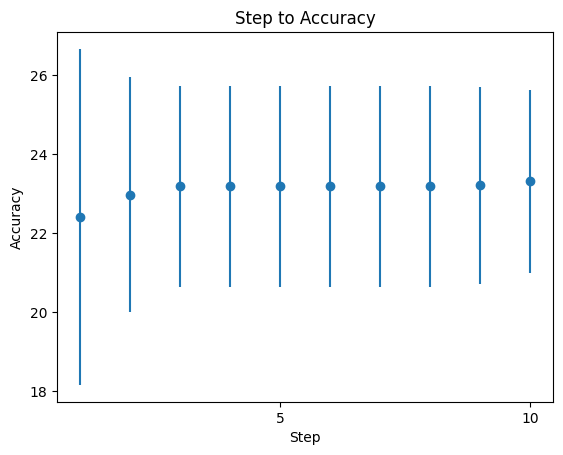

In [8]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [10]:
opro_results[str(len(opro_results))]

{'Please summarize the following text: {TEXT}. Be concise and clear.': 26.591789320078995,
 'Please summarize the following text: {TEXT}. You are a summarization expert.': 26.13727345739138,
 'Please summarize the following text: {TEXT}. Take a deep breath.': 25.78502663670834,
 '**Instruction**: Synthesize complex ideas by summarizing the following text:\n\n**{TEXT}**\n\nYour task is to generate a concise and informative summary of the provided text. Ensure your response is clear, concise, and free from errors. You MUST adhere to the formatting guidelines and provide a single cohesive summary. If you fail to meet these requirements, you will be penalized.\n\nWrite in a natural, human-like manner and ensure your response is comprehensive, covering all main points of the provided text.': 25.51226174786897,
 '#### Instruction ####\n\nSummarize the following text:\n\n#### Input ####\n\n{TEXT}\n\n#### Expected Response Format ####\n\n[Your summary]': 25.16361032162922,
 "###Instruction###\

In [11]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"Initial Prompt: {score(CHOSEN_PROMPT, testing_sample)}")
print(f"Optimized Prompt ({best_instruction}): {score(best_instruction, testing_sample)}")

Please summarize the following text: {TEXT}:   0%|          | 0/30 [00:00<?, ?it/s]

Initial Prompt: 26.810466361069363


Please summarize the following text: {TEXT}. Be concise and clear.:   0%|          | 0/30 [00:00<?, ?it/s]

Optimized Prompt (Please summarize the following text: {TEXT}. Be concise and clear.): 29.08862731805717
